# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE ## For feature selection


In [2]:
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Data
This dataset is from kaggle.com, and it is used to train classificatino models on whether it is going to **rain tomorrow** ('Yes'/'No'). 

In [3]:
df = pd.read_csv("weatherAUS.csv",header=0)
df = df.dropna().reset_index()

In [4]:
df = df.drop('index',axis=1)

In [5]:
# shape: 56420 instances and 23 attributes:
print(df.shape)

(56420, 23)


In [6]:
# head
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
1,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
2,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
3,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
4,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


# Data Exploration

### Dealing with categorical variables (change)
Let's collapse some levels in **Wind Direction** (WindDir9am, WindDir3pm, and WindGustDir):

In [7]:
df.WindGustDir.unique() ## Too many levels

array(['SSW', 'S', 'NNE', 'WNW', 'N', 'SE', 'ENE', 'NE', 'E', 'SW', 'W',
       'WSW', 'NNW', 'ESE', 'SSE', 'NW'], dtype=object)

In [8]:
cat_cols = ['WindDir9am', 'WindDir3pm', 'WindGustDir']
for col in cat_cols:
    df.loc[(df[col] == 'SSW')|(df[col] == 'SSE'), col] = 'S'
    df.loc[(df[col] == 'NNE')|(df[col] == 'NNW'), col] = 'N'
    df.loc[(df[col] == 'WSW')|(df[col] == 'WNW'), col] = 'W'
    df.loc[(df[col] == 'ENE')|(df[col] == 'ESE'), col] = 'E'

In [9]:
print(df.WindDir9am.unique())
print(df.WindDir3pm.unique())
print(df.WindGustDir.unique())

['E' 'S' 'N' 'W' 'NW' 'SE' 'NE' 'SW']
['SW' 'S' 'N' 'W' 'E' 'SE' 'NW' 'NE']
['S' 'N' 'W' 'SE' 'E' 'NE' 'SW' 'NW']


### Dealing with Date Information (change)
Augment data with additional columns...

In [10]:
df['Year'] = df['Date'].str[0:4]
df['Month'] = df['Date'].str[5:7]
df['Day'] = df['Date'].str[8:10]

# df['Year'] = df['Year'].astype('str')
# df['Month'] = df['Month'].astype('int32')
# df['Day'] = df['Day'].astype('int32')

In [11]:
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
Year              object
Month             object
Day               object
dtype: object

### Statistical Summary

In [12]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000


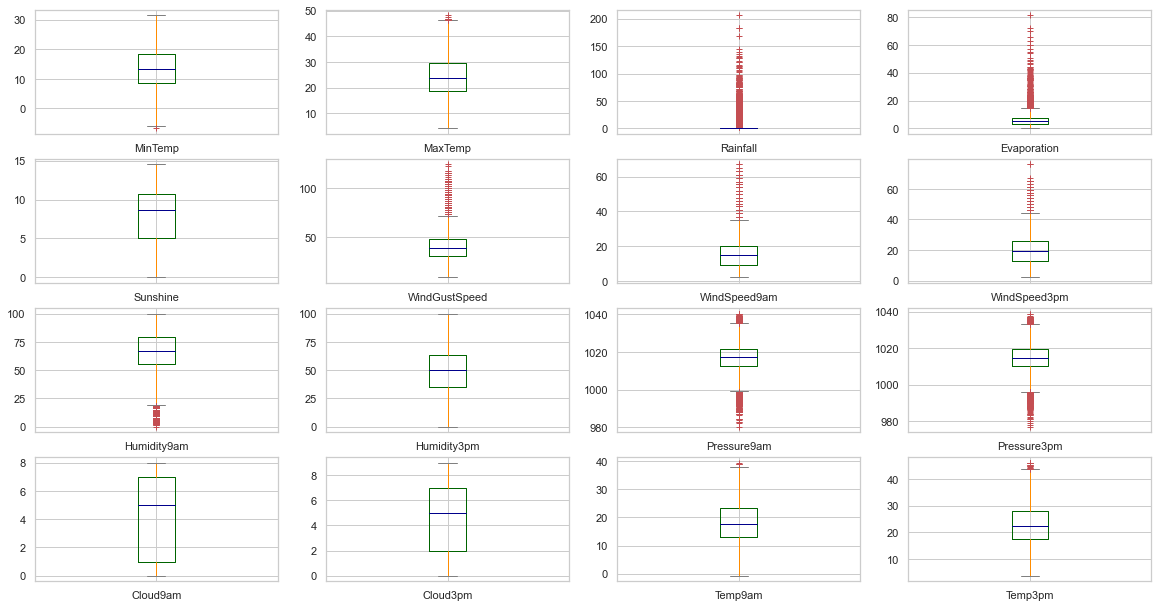

In [13]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')

df.plot(kind='box', subplots=True, layout=(6,4), 
        sharex=False, sharey=False,
        figsize=(20,16), color=color, sym='r+')
plt.show()

In [15]:
# plt.scatter(df['MinTemp'],df["WindGustSpeed"], c = df["RainTomorrow"])

### Outcome Variable (y): RainTomorrow

In [16]:
df['RainTomorrow'].value_counts()

No     43993
Yes    12427
Name: RainTomorrow, dtype: int64

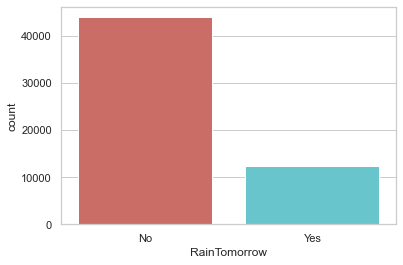

In [17]:
sns.countplot(x = 'RainTomorrow', data=df, palette='hls')
plt.show()

In [18]:
count_no = len(df[df.RainTomorrow == 'No'])
count_yes = len(df[df.RainTomorrow == 'Yes'])
total = len(df)

print(f"There are {len(df[df.RainTomorrow == 'Yes'])} days that will rain tomorrow. ", 
      f"\nThere are {len(df[df.RainTomorrow == 'No'])} days that would not rain tomorrow.")
print("\nPercentage of raining is about {0:.2%}".format(count_yes/total))
print("Percentage of non-raining is about {0:.2%}".format(count_no/total))

There are 12427 days that will rain tomorrow.  
There are 43993 days that would not rain tomorrow.

Percentage of raining is about 22.03%
Percentage of non-raining is about 77.97%


In [19]:
df.groupby('RainTomorrow').mean()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
RainTomorrow,,,,,,,,,,,,,,,,
No,13.166611,24.765538,1.182149,5.758525,8.641254,39.224877,15.296343,19.384857,63.207306,44.714023,1018.175237,1015.637006,3.760075,3.779806,18.268420,23.377392
Yes,14.520286,22.285129,5.487302,4.599026,4.529597,46.727368,16.980204,21.209624,75.314959,66.905931,1013.926909,1011.816834,5.946729,6.261930,17.980309,20.348869


In [20]:
df.groupby('WindGustDir').mean()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
WindGustDir,,,,,,,,,,,,,,,,
E,15.560940,26.823237,1.650734,6.292004,8.533738,37.863782,15.284160,18.569922,62.844045,47.686488,1018.562551,1015.472174,3.820175,3.819416,20.765697,25.419602
N,12.757837,24.410483,1.345092,5.063017,7.209595,42.634942,16.795896,19.916473,65.376373,48.366167,1016.848408,1013.470782,4.300832,4.697282,17.759201,22.950804
NE,15.957896,27.144364,1.508885,6.136641,8.716672,36.421036,13.328728,18.518053,63.257457,50.343799,1017.904019,1014.466279,3.581476,3.725589,21.465746,25.651680
NW,12.074541,23.543683,2.146784,4.598009,7.310337,44.578867,15.487366,20.907351,66.192190,48.476263,1014.530475,1011.797435,4.392802,4.726646,17.055934,21.955245
S,13.202041,23.114821,2.644769,5.604294,7.419910,40.010250,15.485640,19.611414,68.197156,51.762582,1018.422403,1016.683212,4.575861,4.383415,17.295771,21.567753
SE,15.434529,25.727557,2.620712,6.248295,8.032392,38.970483,16.011196,19.413232,65.101018,49.288804,1018.414326,1015.914911,4.238422,4.171501,19.865802,24.236641
SW,11.851407,22.400740,2.296224,5.418583,7.887290,41.109822,14.905726,19.824038,66.462488,49.446693,1017.013006,1015.582897,4.272705,4.226802,16.535439,20.786624
W,11.531926,21.774280,2.727612,4.706133,7.269857,44.565488,16.214240,21.394297,68.014075,50.780276,1015.072461,1013.403656,4.464857,4.686226,16.044054,20.195448


In [21]:
df.groupby('Year').mean()[['Temp9am','Temp3pm']]

,Temp9am,Temp3pm
Year,,
2007,17.267213,23.455738
2008,16.949384,21.547920
2009,18.139635,22.952710
2010,17.664317,22.030406
2011,18.063509,22.465224
2012,17.593271,22.162691
2013,18.396633,22.852757
2014,18.727233,23.249782
2015,18.536129,22.904779


In [22]:
## Australia's Winter in our summer time...
df.groupby('Month').mean()[['Temp9am','Temp3pm']]

,Temp9am,Temp3pm
Month,,
01,23.440991,28.249022
02,22.689265,27.761173
03,20.811500,26.045361
04,18.836183,23.247196
05,15.327921,19.845118
06,12.803943,17.413954
07,12.252771,16.967488
08,13.751142,18.203511
09,16.648965,20.381242


## Visualization

In [23]:
import matplotlib
%matplotlib inline

In [24]:
# City/ Location Counts
cities = df.Location.unique().tolist()
cities_len = []
for city in cities:
    city_len = len(df.loc[df.Location == city])
    cities_len.append(city_len)
    
print("City Names and their corresponding counts...")    
print("\n",list(zip(cities, cities_len)))

City Names and their corresponding counts...

 [('Cobar', 534), ('CoffsHarbour', 1380), ('Moree', 1913), ('NorfolkIsland', 2464), ('Sydney', 1690), ('SydneyAirport', 2870), ('WaggaWagga', 2416), ('Williamtown', 1198), ('Canberra', 1078), ('Sale', 1678), ('MelbourneAirport', 2929), ('Melbourne', 1898), ('Mildura', 2594), ('Portland', 1863), ('Watsonia', 2730), ('Brisbane', 2953), ('Cairns', 2444), ('Townsville', 2419), ('MountGambier', 2465), ('Nuriootpa', 2008), ('Woomera', 1734), ('PerthAirport', 2913), ('Perth', 3025), ('Hobart', 1939), ('AliceSprings', 2223), ('Darwin', 3062)]


Text(0, 0.5, 'Total counts of Rain/ No-Rain days')

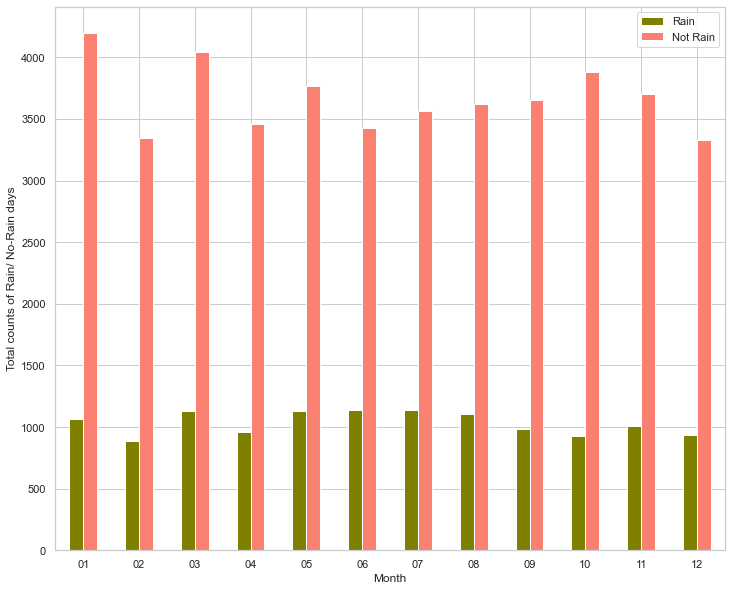

In [25]:
# Total by Month
monthly = df.groupby(['Month','RainTomorrow']).count()['MinTemp']
monthly.to_frame()

positive_values = monthly[:,"Yes"].to_list()
negative_values = monthly[:,"No"].to_list()
index = monthly.unstack(level=-1).index.to_list()

df_monthly = pd.DataFrame({'Rain': positive_values,
                    'Not Rain': negative_values}, index=index)

ax = df_monthly.plot.bar(rot=0, color={'Rain': "olive", 'Not Rain': "salmon"}, figsize=(12,10))
ax.set_xlabel("Month")
ax.set_ylabel("Total counts of Rain/ No-Rain days")

Text(0, 0.5, 'Total counts of Rain/ No-Rain days')

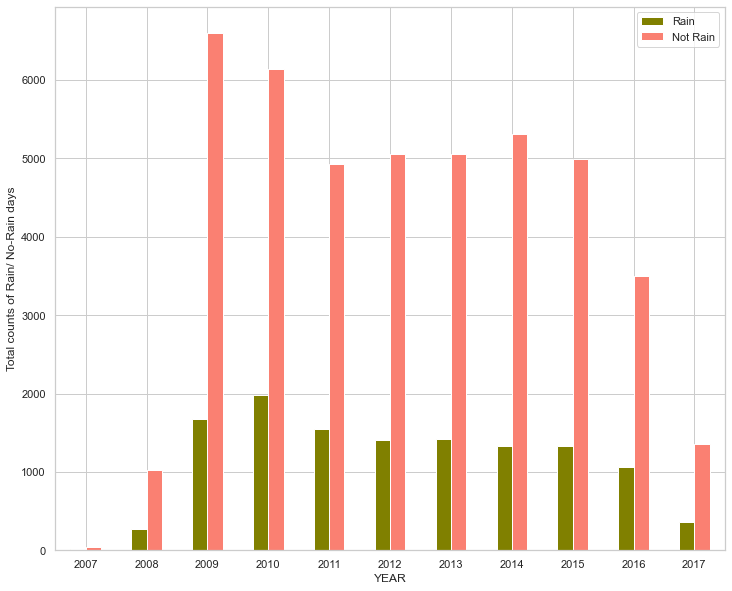

In [26]:
# Total by Year
yearly = df.groupby(['Year','RainTomorrow']).count()['MinTemp']
yearly.to_frame()

positive_values = yearly[:,"Yes"].to_list()
negative_values = yearly[:,"No"].to_list()
index = yearly.unstack(level=-1).index.to_list()

df_yearly = pd.DataFrame({'Rain': positive_values,
                    'Not Rain': negative_values}, index=index)

ax = df_yearly.plot.bar(rot=0, color={'Rain': "olive", 'Not Rain': "salmon"}, figsize=(12,10))
ax.set_xlabel("YEAR")
ax.set_ylabel("Total counts of Rain/ No-Rain days")

Text(0, 0.5, 'Average of Rainfall by City')

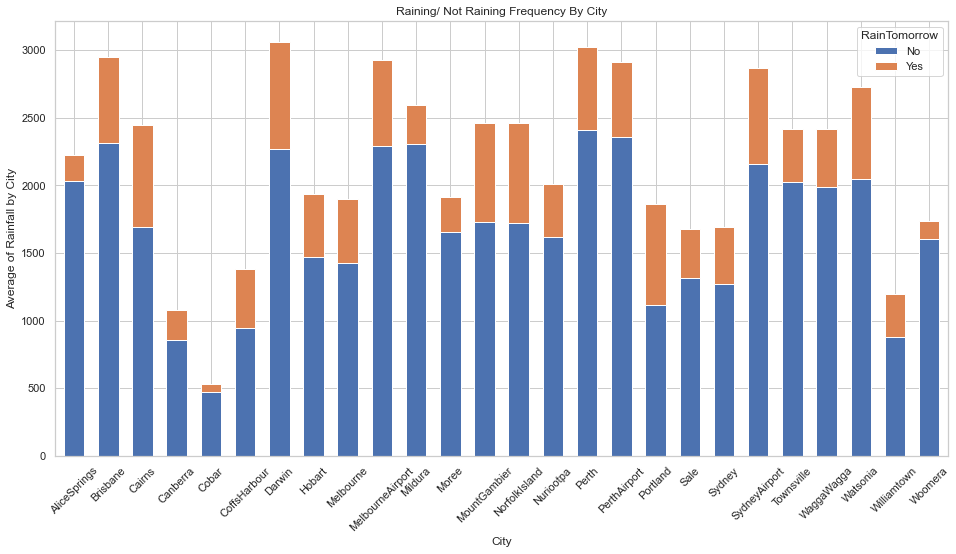

In [27]:
# df['Day'] = df['Day'].astype('object')

pd.crosstab(df.Location, df.RainTomorrow).plot(kind='bar', figsize=(16,8),width=0.6,stacked=True, rot=45)
plt.title('Raining/ Not Raining Frequency By City')
plt.xlabel('City')
plt.ylabel('Average of Rainfall by City')

In [28]:
df.groupby("Location").mean().iloc[:,0:16]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
Location,,,,,,,,,,,,,,,,
AliceSprings,13.878093,29.724921,0.955556,9.017994,9.539316,41.418803,16.008547,18.458839,38.484930,24.024741,1016.260189,1012.446154,2.780927,3.206028,22.043140,28.457175
Brisbane,16.365628,26.436810,2.855401,5.444836,8.171182,28.288520,7.118862,11.131730,63.627159,53.421944,1018.343109,1015.220386,3.845242,3.827294,21.815137,24.746834
Cairns,21.129296,29.551596,4.522259,6.030401,7.664362,38.084288,16.097381,22.086334,69.167758,60.927987,1014.165548,1011.116899,4.420622,4.289280,25.790139,27.872013
Canberra,7.727829,20.363822,1.906957,4.329314,7.399536,40.466605,11.117811,18.455473,72.875696,47.141929,1018.362338,1015.762152,4.353432,4.333952,12.839239,18.917254
Cobar,13.828090,26.225281,1.182397,6.648315,8.728839,36.262172,13.404494,13.649813,55.307116,34.838951,1017.679213,1015.063670,3.061798,3.702247,18.523783,24.873034
CoffsHarbour,14.485000,23.766304,3.885942,3.882464,7.443261,39.116667,15.589855,21.240580,67.551449,61.784058,1018.001087,1015.653768,3.983333,4.226812,20.072174,22.193478
Darwin,23.166492,32.559536,4.038210,6.318746,8.596571,40.429784,15.134226,20.847485,68.111039,51.338668,1011.984095,1008.425114,4.277923,4.264206,27.170967,31.110320
Hobart,8.957091,17.783961,1.624033,3.632749,6.681227,47.743167,16.560083,19.812274,65.402269,52.495101,1014.606034,1013.032852,4.805054,4.946364,12.362249,16.096287
Melbourne,11.672445,20.590253,1.912118,4.534668,6.357271,45.295047,18.896733,21.692835,67.349842,51.336670,1017.615911,1015.776607,5.290306,5.294521,14.501370,19.087777


#### Frequency by Wind Direction (WindGustDir)
The direction of the strongest wind gust in the 24 hours to midnight.

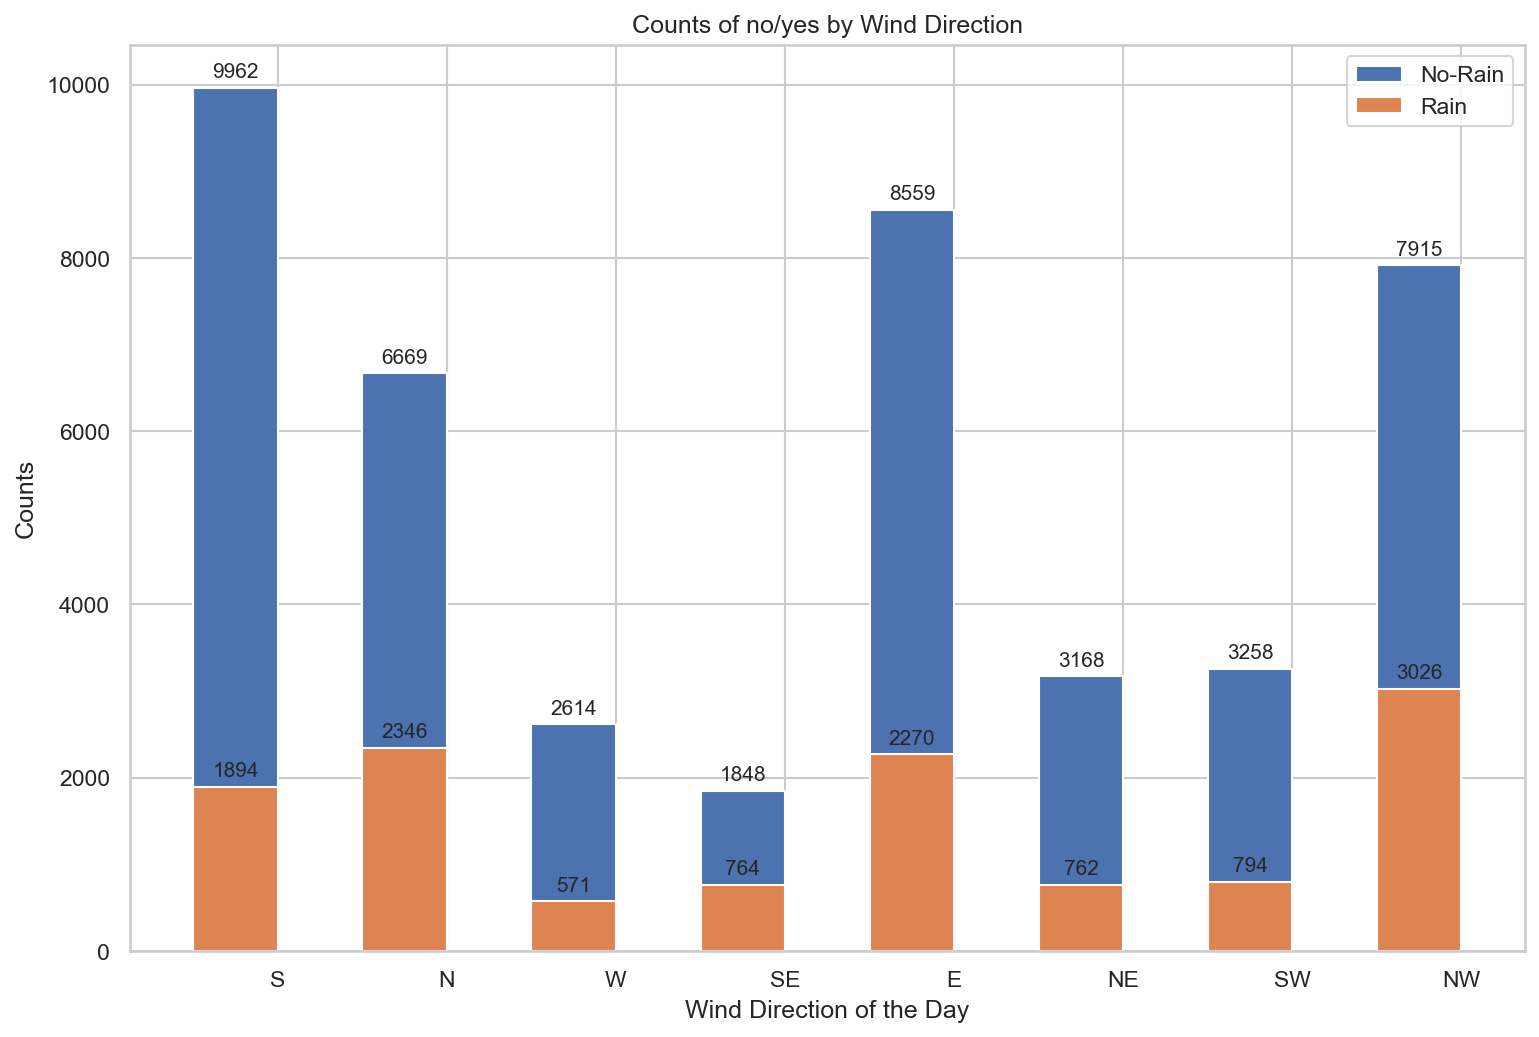

In [29]:
labels = list(df.WindGustDir.unique())
count_no_byWind = df[df.RainTomorrow == 'No'].groupby('WindGustDir').count()['MinTemp'].to_list()
count_yes_byWind = df[df.RainTomorrow == 'Yes'].groupby('WindGustDir').count()['MinTemp'].to_list()

x = np.arange(len(labels)) ## Label locations
width = 0.5 #Width of the bars

fig, ax = plt.subplots(figsize=(12,8), dpi=150)

rects1 = ax.bar(x - width/2, count_no_byWind, width=width, label = "No-Rain")
rects2 = ax.bar(x - width/2, count_yes_byWind, width=width, label = "Rain")

## Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Counts of no/yes by Wind Direction')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Wind Direction of the Day")
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

# fig.tight_layout()
fig.savefig("img1.png")
plt.show()




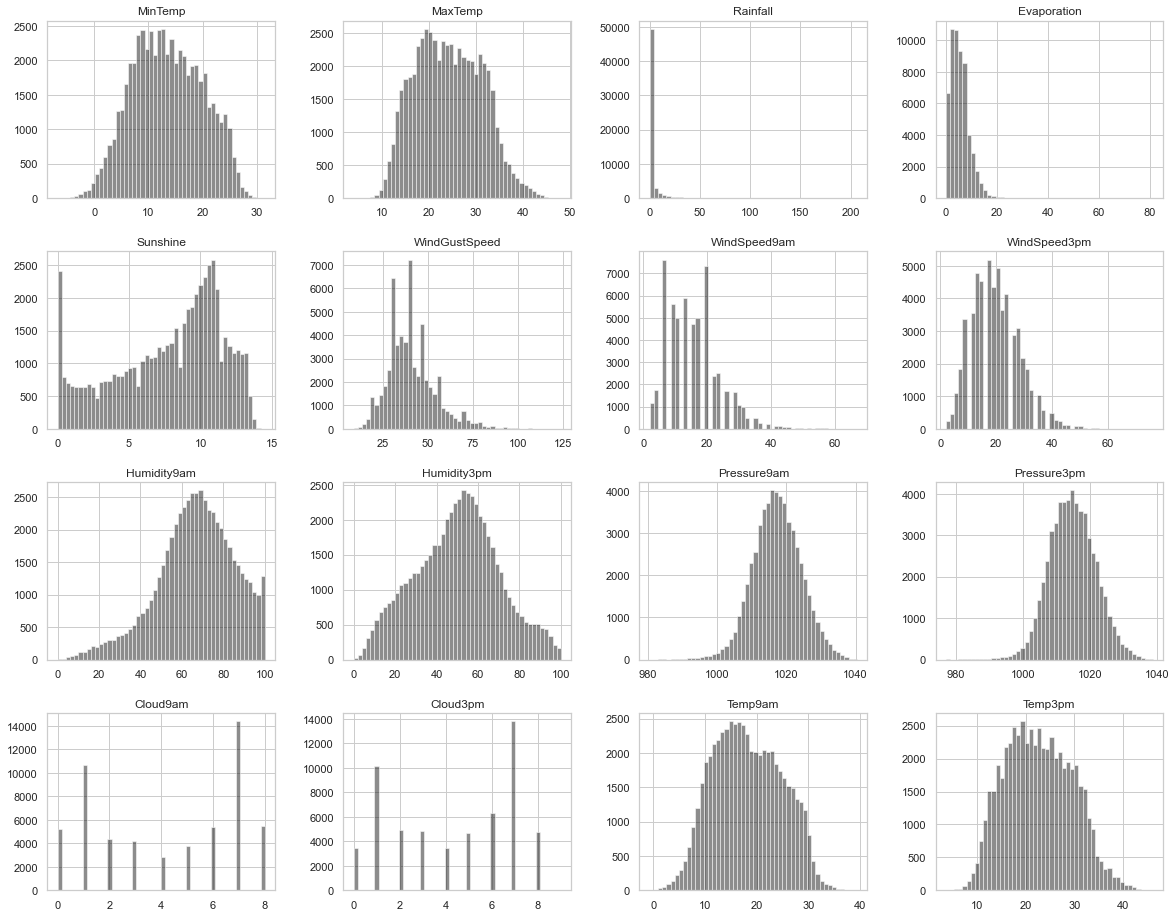

In [30]:
df.hist(bins=50, figsize=(20,16), color='k', alpha=0.5)
# plt.savefig('big_histpng')
plt.show()

Text(0, 0.5, 'Frequency')

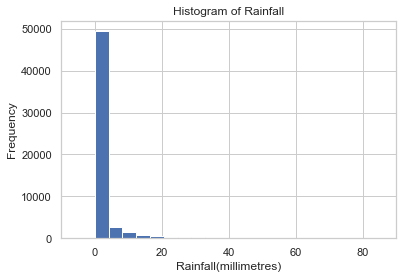

In [31]:
df.Rainfall.hist(bins=50)
plt.title('Histogram of Rainfall')
plt.xlim(-10,90)
plt.xlabel('Rainfall(millimetres)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

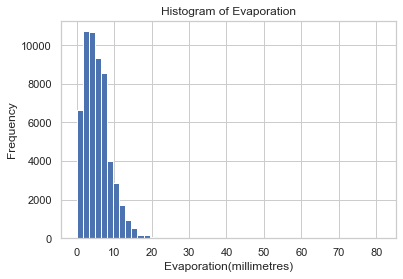

In [32]:
df.Evaporation.hist(bins=50)
plt.title('Histogram of Evaporation')
plt.xlabel('Evaporation(millimetres)')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

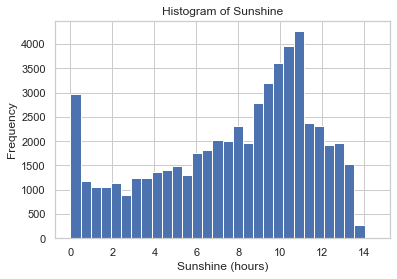

In [33]:
df.Sunshine.hist(bins=30)
plt.title('Histogram of Sunshine')
plt.xlabel('Sunshine (hours)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

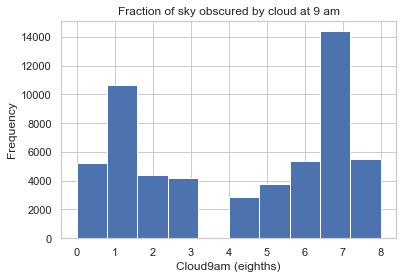

In [34]:
df.Cloud9am.hist(bins=10)
plt.title('Fraction of sky obscured by cloud at 9 am')
plt.xlabel('Cloud9am (eighths)')
plt.ylabel('Frequency')


### Correlation Matrix (heatmap)

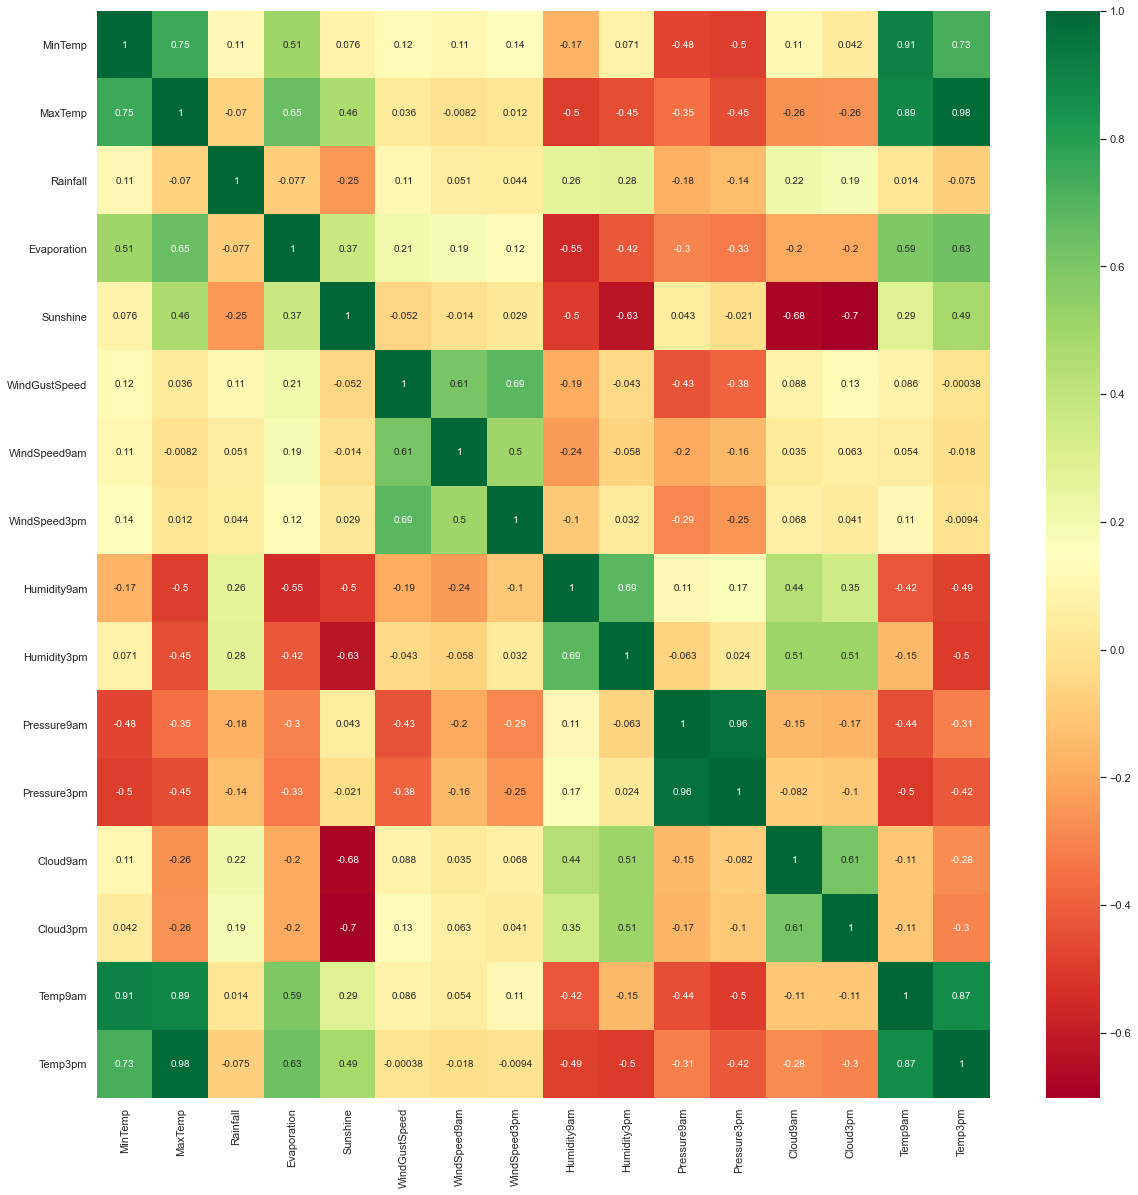

In [35]:
X = df.iloc[:, 0:26]
y = df.iloc[:,-1]
corrmat = df.corr()

top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Modeling
## Data Preparation

## Dummy Variables

In [36]:
cat_vars = ['WindDir9am', 'WindDir3pm', 'WindGustDir', 'RainToday']

for var in cat_vars:
    cat_list = pd.get_dummies(df[var], prefix=var)
    df = df.join(cat_list)

In [37]:
## DROP the Old Cat vars: 
df_final = df.drop(cat_vars, axis=1)

In [38]:
## DROP Date,Locaion, Year Month Day
df_final = df_final.drop(['Date', 'Location','Year','Month', 'Day'],axis=1)
df_final.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainTomorrow', 'WindDir9am_E', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SW', 'WindDir9am_W', 'WindDir3pm_E', 'WindDir3pm_N',
       'WindDir3pm_NE', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SW', 'WindDir3pm_W', 'WindGustDir_E', 'WindGustDir_N',
       'WindGustDir_NE', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SW', 'WindGustDir_W', 'RainToday_No', 'RainToday_Yes'],
      dtype='object')

In [39]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindGustDir_E,WindGustDir_N,WindGustDir_NE,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SW,WindGustDir_W,RainToday_No,RainToday_Yes
0,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,S,48.0,E,...,0,0,0,0,1,0,0,0,1,0
1,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,S,...,0,0,0,0,1,0,0,0,1,0
2,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,N,46.0,N,...,0,1,0,0,0,0,0,0,1,0
3,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,W,31.0,W,...,0,0,0,0,0,0,0,1,1,0
4,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,W,35.0,NW,...,0,0,0,0,0,0,0,1,1,0


## Label Encoding

In [40]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Check the labels
label_encoder.fit(df_final['RainTomorrow'])
label_encoder.classes_ 

# transform
df_final['RainTomorrow'] = label_encoder.transform(df_final.RainTomorrow)

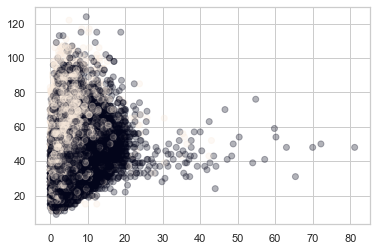

In [41]:
plt.scatter(df_final['Evaporation'],df_final["WindGustSpeed"], c = df_final["RainTomorrow"], alpha=0.3)
plt.show()

In [51]:
X = df_final.loc[:, df_final.columns != 'RainTomorrow']
y = df_final.loc[:, df_final.columns == 'RainTomorrow']

### Split Input and Output Features

In [43]:
# df_final.columns[-27]

In [44]:
# X, y = df_final.values[:, :-27], df_final.values[:, -27]

 Over sampling using SMOTE
https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

https://stats.stackexchange.com/questions/234016/opinions-about-oversampling-in-general-and-the-smote-algorithm-in-particular

https://arxiv.org/pdf/1106.1813.pdf
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
# from imblearn.over_sampling import SMOTE

# os = SMOTE(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
# columns = X_train.columns

# os_data_X, os_data_y = os.fit_sample(X_train, y_train)
# os_data_X = pd.DataFrame(data = os_data_X, columns=columns)
# os_data_y = pd.DataFrame(data = os_data_y, columns=['RainTomorrow'])

# # we can Check the numbers of our data
# print("length of oversampled data is ",len(os_data_X))
# print("Number of not raining in oversampled data",len(os_data_y[os_data_y['RainTomorrow']==0]))
# print("Number of raining",len(os_data_y[os_data_y['RainTomorrow']==1]))
# print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['RainTomorrow']==0])/len(os_data_X))
# print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['RainTomorrow']==1])/len(os_data_X))

## Feature Selection: 
### 1. Embedded: feature importance

Feature: 0, Score: -0.04468
Feature: 1, Score: 0.04448
Feature: 2, Score: 0.03165
Feature: 3, Score: -0.03472
Feature: 4, Score: -0.15827
Feature: 5, Score: 0.06897
Feature: 6, Score: -0.02156
Feature: 7, Score: -0.01925
Feature: 8, Score: 0.00017
Feature: 9, Score: 0.05745
Feature: 10, Score: 0.07948
Feature: 11, Score: -0.08723
Feature: 12, Score: 0.01119
Feature: 13, Score: 0.12164
Feature: 14, Score: 0.01349
Feature: 15, Score: 0.03837
Feature: 16, Score: -0.00485
Feature: 17, Score: 0.02454
Feature: 18, Score: 0.00645
Feature: 19, Score: 0.00164
Feature: 20, Score: -0.01981
Feature: 21, Score: -0.00715
Feature: 22, Score: -0.00197
Feature: 23, Score: 0.00182
Feature: 24, Score: -0.01043
Feature: 25, Score: 0.02060
Feature: 26, Score: -0.00102
Feature: 27, Score: 0.00920
Feature: 28, Score: -0.01982
Feature: 29, Score: -0.00179
Feature: 30, Score: -0.00727
Feature: 31, Score: 0.01120
Feature: 32, Score: -0.01144
Feature: 33, Score: 0.01216
Feature: 34, Score: -0.00019
Feature: 35, 

/Users/meixi/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


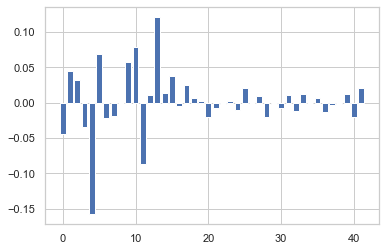

In [45]:
# Feature Importance
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model = LogisticRegression()
model.fit(X, y.values.ravel())

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### NOTE: 
Recall this is a classification problem with classes 0 and 1. 
Notice that the coefficients are both positive and negative. 
The positive scores indicate a feature that predicts class 1, 
whereas the negative scores indicate a feature that predicts class 0.

**No clear pattern** of important and unimportant features can be identified from these results, 
at least from what I can tell.

**Why:** embeded feature importance is better with ensembles of tree-based method. 


### 2. Recursive Feature Elimination (RFE)   

**NOTE: <u>Here is just an shorter version, we will run the full length one after the first model</u>**

https://scikit-learn.org/stable/modules/feature_selection.html

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. 

First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_) or callable. 

Then, the least important features are pruned from current set of features. 

That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [67]:
df_final_vars = df_final.columns.values.tolist()
features = [i for i in df_final_vars if i not in y]

In [68]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 30) 
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/Users/meixi/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/meixi/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

[ True  True  True  True  True  True  True  True False  True  True  True
 False  True False  True False  True  True False  True  True False False
  True  True False  True  True False  True  True  True  True False  True
  True False False  True  True  True]
[ 1  1  1  1  1  1  1  1 13  1  1  1  3  1  2  1  4  1  1  9  1  1  7  6
  1  1 10  1  1  8  1  1  1  1 12  1  1  5 11  1  1  1]


/Users/meixi/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [69]:
selected_cols = []
for f, s in zip(features,rfe.support_):
    if s == True:
        selected_cols.append(f)       
print(selected_cols)

## Another way to do it
# vals, cols = zip(*[(val, col) for val, col in zip(rfe.support_,features) if val == True])
# list(cols)
len(selected_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp3pm', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_S', 'WindDir9am_SE', 'WindDir3pm_E', 'WindDir3pm_N', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SW', 'WindDir3pm_W', 'WindGustDir_E', 'WindGustDir_N', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_W', 'RainToday_No', 'RainToday_Yes']


30

In [54]:
X = df_final.loc[:, df_final.columns != 'RainTomorrow']
y = df_final.loc[:, df_final.columns == 'RainTomorrow']

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [56]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
# Transform
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

/Users/meixi/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [57]:
y_pred = logreg.predict(X_test_scaled)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


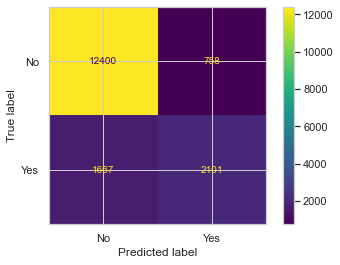

In [58]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# confusion_matrix = confusion_matrix(y_test, y_pred)
# print(confusion_matrix)
plot_confusion_matrix(logreg,X_test_scaled,y_test, 
                     values_format='d', 
                     display_labels=["No","Yes"])

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     13158
           1       0.73      0.56      0.63      3768

    accuracy                           0.86     16926
   macro avg       0.81      0.75      0.77     16926
weighted avg       0.85      0.86      0.85     16926



## Full length RFE

In [60]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [61]:
from sklearn.metrics import accuracy_score
rfes = []

for n in range(1,43):
    logreg = LogisticRegression()
    rfe = RFE(logreg, n, 1).fit(X_train_scaled, y_train.values.ravel())
    rfes.append(rfe)
    print("Running ...")
print("Done!")

Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...
Running ...


In [62]:
scores = []
for r in rfes:
    y_Hat = r.predict(X_train_scaled)
    score = accuracy_score(y_train, y_Hat)
    scores.append(score)

for r, s in zip(rfes,scores):
    if s == max(scores):
        best_rfe = r
        results = best_rfe.support_
results

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False, False,  True, False,
       False,  True,  True,  True, False, False,  True, False, False,
        True,  True,  True,  True,  True,  True])

In [63]:
vals, cols = zip(*[(val, col) for val, col in zip(results,features) if val == True])
cols = list(cols)
cols

['MinTemp',
 'Rainfall',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'WindDir9am_E',
 'WindDir9am_N',
 'WindDir9am_NE',
 'WindDir9am_S',
 'WindDir9am_SE',
 'WindDir3pm_N',
 'WindDir3pm_S',
 'WindDir3pm_SE',
 'WindDir3pm_SW',
 'WindGustDir_N',
 'WindGustDir_S',
 'WindGustDir_SE',
 'WindGustDir_SW',
 'WindGustDir_W',
 'RainToday_No',
 'RainToday_Yes']

### Use the new columns to model

In [64]:
X_new = X[cols]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=0)

X_scaler = StandardScaler().fit(X_train)
# Transform
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)
print('Accuracy of logistic regression classifier on test set: {:.0f}%'.format(100*(logreg.score(X_test_scaled, y_test))))

Accuracy of logistic regression classifier on test set: 86%


/Users/meixi/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [65]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[12403   755]
 [ 1666  2102]]


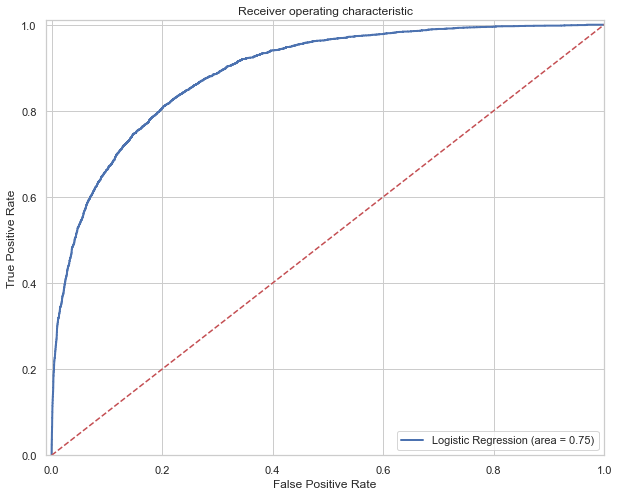

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_scaled))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, lw=2, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC.png')
plt.show()